***IMPORTS***

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split, Dataset

***GENERATE 6 DIMENSIONAL DATA***

In [3]:
def rotation_matrix_6D(theta, dim1, dim2):
    """
    Create a 6D rotation matrix to rotate by angle theta in the plane defined by dim1 and dim2.
    
    Parameters:
    - theta: Rotation angle in radians.
    - dim1, dim2: Dimensions (0-5) in which rotation should occur.
    
    Returns:
    - 6x6 rotation matrix.
    """
    R2 = np.array([[np.cos(theta), -np.sin(theta)],
                   [np.sin(theta), np.cos(theta)]])
    
    R6 = np.eye(6) # create identity matrix of 6*6
    R6[dim1, dim1], R6[dim1, dim2], R6[dim2, dim1], R6[dim2, dim2] = R2.flatten()
    
    return R6

In [4]:
def generate_data_6D(n_samples_per_class=100, n_classes=5):
    """
    Generate data for n_classes in a 6D space.

    Parameters:
    - n_samples_per_class: Number of samples per class.
    - n_classes: Number of classes.

    Returns:
    - X: Data points.
    - y: Class targets.
    """
    
    # Define means for the classes in 6D space
    means = [tuple(i*2 for _ in range(6)) for i in range(n_classes)]

    # Define a covariance matrix for 6D
    # Base covariance defines how spread out the data is in that dimension
    base_covariance = np.array([[0.2, 0, 0, 0, 0, 0], 
                                [0, 5, 0, 0, 0, 0],
                                [0, 0, 0.2, 0, 0, 0],
                                [0, 0, 0, 5, 0, 0],
                                [0, 0, 0, 0, 0.2, 0],
                                [0, 0, 0, 0, 0, 5]])
    
    theta = np.pi / 4  # or any other desired angle
    # R = rotation_matrix_6D(theta, 0, 1)  # for rotation in the plane of the first two dimensions
    
    R1 = rotation_matrix_6D(theta, 0, 1)
    R2 = rotation_matrix_6D(theta, 2, 3)
    R3 = rotation_matrix_6D(theta, 4, 5)
    covariance = R1 @ R2 @ R3 @ base_covariance @ R3.T @ R2.T @ R1.T
    
    X = np.empty((0, 6))
    y = np.empty((0,))

    for idx, mean in enumerate(means):
        class_data = np.random.multivariate_normal(mean, covariance, n_samples_per_class)
        X = np.vstack([X, class_data])
        y = np.hstack([y, [idx]*n_samples_per_class])

    return X, y

In [5]:
# Generate and plot the data
n_classes = 5
X, y = generate_data_6D(n_samples_per_class = 400, n_classes=n_classes)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
# #relable the data
# mapping = {0: 0, 2: 1, 4: 2}

# y_primary_train_pretain = torch.LongTensor([mapping[c] for c in y_primary_train])
# y_primary_val_pretain = torch.LongTensor([mapping[c] for c in y_primary_val])
# y_primary_test_pretain = torch.LongTensor([mapping[c] for c in y_primary_test])

# #relabeling 

# mapping = {1: 0, 3: 1}

# y_transfer_train_v1 = np.array([mapping[label] for label in y_transfer_train])
# y_transfer_val_v1 = np.array([mapping[label] for label in y_transfer_val])
# y_transfer_test_v1 = np.array([mapping[label] for label in y_transfer_test])

In [8]:
# Assuming CustomDataset is already defined elsewhere in your code

# Split the data into primary (even classes) and transfer (odd classes) datasets
X_primary = X[np.isin(y, [0, 2, 4])]
y_primary = y[np.isin(y, [0, 2, 4])]

# Convert primary data to PyTorch tensors
X_primary = torch.tensor(X_primary, dtype=torch.float32)
y_primary = torch.tensor(y_primary, dtype=torch.int64)

primary_dataset = CustomDataset(X_primary, y_primary)

X_transfer = X[np.isin(y, [1, 3])]
y_transfer = y[np.isin(y, [1, 3])]

# Convert transfer data to PyTorch tensors
X_transfer = torch.tensor(X_transfer, dtype=torch.float32)
y_transfer = torch.tensor(y_transfer, dtype=torch.int64)

transfer_dataset = CustomDataset(X_transfer, y_transfer)

# Splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the primary dataset
primary_train_size = int(train_ratio * len(primary_dataset))
primary_val_size = int(val_ratio * len(primary_dataset))
primary_test_size = len(primary_dataset) - primary_train_size - primary_val_size

primary_train_dataset, primary_val_dataset, primary_test_dataset = random_split(primary_dataset, [primary_train_size, primary_val_size, primary_test_size])

# Split the transfer dataset
transfer_train_size = int(train_ratio * len(transfer_dataset))
transfer_val_size = int(val_ratio * len(transfer_dataset))
transfer_test_size = len(transfer_dataset) - transfer_train_size - transfer_val_size

transfer_train_dataset, transfer_val_dataset, transfer_test_dataset = random_split(transfer_dataset, [transfer_train_size, transfer_val_size, transfer_test_size])

# Extract the labels from primary dataset splits
y_primary_train = [data[1] for data in primary_train_dataset]
y_primary_val = [data[1] for data in primary_val_dataset]
y_primary_test = [data[1] for data in primary_test_dataset]

# Relabel the primary data
mapping_primary = {0: 0, 2: 1, 4: 2}
y_primary_train_pretain = torch.LongTensor([mapping_primary[c.item()] for c in y_primary_train])
y_primary_val_pretain = torch.LongTensor([mapping_primary[c.item()] for c in y_primary_val])
y_primary_test_pretain = torch.LongTensor([mapping_primary[c.item()] for c in y_primary_test])

# Update the primary datasets with the new labels
primary_train_dataset = CustomDataset([data[0] for data in primary_train_dataset], y_primary_train_pretain)
primary_val_dataset = CustomDataset([data[0] for data in primary_val_dataset], y_primary_val_pretain)
primary_test_dataset = CustomDataset([data[0] for data in primary_test_dataset], y_primary_test_pretain)

# Extract the labels from transfer dataset splits
y_transfer_train = [data[1] for data in transfer_train_dataset]
y_transfer_val = [data[1] for data in transfer_val_dataset]
y_transfer_test = [data[1] for data in transfer_test_dataset]

# Relabel the transfer data
mapping_transfer = {1: 0, 3: 1}
y_transfer_train_v1 = torch.LongTensor([mapping_transfer[c.item()] for c in y_transfer_train])
y_transfer_val_v1 = torch.LongTensor([mapping_transfer[c.item()] for c in y_transfer_val])
y_transfer_test_v1 = torch.LongTensor([mapping_transfer[c.item()] for c in y_transfer_test])

# Update the transfer datasets with the new labels
transfer_train_dataset = CustomDataset([data[0] for data in transfer_train_dataset], y_transfer_train_v1)
transfer_val_dataset = CustomDataset([data[0] for data in transfer_val_dataset], y_transfer_val_v1)
transfer_test_dataset = CustomDataset([data[0] for data in transfer_test_dataset], y_transfer_test_v1)

# Create DataLoader objects
batch_size = 32
primary_train_loader = DataLoader(primary_train_dataset, batch_size=batch_size, shuffle=True)
primary_val_loader = DataLoader(primary_val_dataset, batch_size=batch_size, shuffle=False)
primary_test_loader = DataLoader(primary_test_dataset, batch_size=batch_size, shuffle=False)

transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=batch_size, shuffle=True)
transfer_val_loader = DataLoader(transfer_val_dataset, batch_size=batch_size, shuffle=False)
transfer_test_loader = DataLoader(transfer_test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
def check_unique_labels(loader):
    labels_list = []
    for _, labels in loader:
        labels_list.extend(labels.numpy())
    return np.unique(labels_list)

print("Unique labels in primary_train_loader:", check_unique_labels(primary_train_loader))
print("Unique labels in primary_val_loader:", check_unique_labels(primary_val_loader))
print("Unique labels in primary_test_loader:", check_unique_labels(primary_test_loader))

print("\nUnique labels in transfer_train_loader:", check_unique_labels(transfer_train_loader))
print("Unique labels in transfer_val_loader:", check_unique_labels(transfer_val_loader))
print("Unique labels in transfer_test_loader:", check_unique_labels(transfer_test_loader))


Unique labels in primary_train_loader: [0 1 2]
Unique labels in primary_val_loader: [0 1 2]
Unique labels in primary_test_loader: [0 1 2]

Unique labels in transfer_train_loader: [0 1]
Unique labels in transfer_val_loader: [0 1]
Unique labels in transfer_test_loader: [0 1]


In [10]:
# Define the network architecture
class DenseNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob = 0.15):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

In [11]:
# Hyperparameters
input_dim = 6
hidden_dim = 128
output_dim = 3
output_dim_trnsfr = 2

In [12]:
# Initialize the network and optimizer
model = DenseNet(input_dim, hidden_dim, output_dim)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [13]:
# Training loop
epochs = 50
patience = 5  # Number of epochs to wait before stopping
wait = 0
best_loss = float('inf')

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for data, target in primary_train_loader:
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = criterion(output.to(device), target.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(primary_train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in primary_val_loader:
            output = model(data.to(device))
            loss = criterion(output.to(device), target.to(device))
            val_loss += loss.item()
    
    val_loss /= len(primary_val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # Check early stopping condition
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

Epoch 1/50 - Training Loss: 0.8073701284549855, Validation Loss: 0.536885678768158
Epoch 2/50 - Training Loss: 0.34814251241860567, Validation Loss: 0.22932115445534387
Epoch 3/50 - Training Loss: 0.30791422228018445, Validation Loss: 0.20608970895409584
Epoch 4/50 - Training Loss: 0.22862168732616636, Validation Loss: 0.188638457407554
Epoch 5/50 - Training Loss: 0.19875938169382237, Validation Loss: 0.17765340954065323
Epoch 6/50 - Training Loss: 0.14932033433406441, Validation Loss: 0.10194850340485573
Epoch 7/50 - Training Loss: 0.1503572959314894, Validation Loss: 0.09484718988339107
Epoch 8/50 - Training Loss: 0.09967841247648553, Validation Loss: 0.0576964799935619
Epoch 9/50 - Training Loss: 0.09751550032308808, Validation Loss: 0.03423343971371651
Epoch 10/50 - Training Loss: 0.07603738315541435, Validation Loss: 0.031141832936555147
Epoch 11/50 - Training Loss: 0.07001609320717829, Validation Loss: 0.020649848505854607
Epoch 12/50 - Training Loss: 0.06771533046331671, Validat

In [14]:
class TransferModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_transfer, dropout_prob=0.15):
        super(TransferModel, self).__init__()
        # Copy the layers from the pretrained model
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        
        # Add the new final layer
        self.fc_final = nn.Linear(hidden_dim, output_dim_transfer)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc_final(x)
        return x

In [15]:
# Assuming pretrained_model is an instance of DenseNet that has been trained
pretrained_model = DenseNet(input_dim, hidden_dim, output_dim)

In [16]:
print(pretrained_model)

DenseNet(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (dropout): Dropout(p=0.15, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=3, bias=True)
)


In [17]:
# Create the transfer model
transfer_model = TransferModel(input_dim, hidden_dim, output_dim_trnsfr)
transfer_model.to(device)

# Copy weights from the pretrained model
with torch.no_grad():
    transfer_model.fc1.weight.copy_(pretrained_model.fc1.weight)
    transfer_model.fc1.bias.copy_(pretrained_model.fc1.bias)
    transfer_model.fc2.weight.copy_(pretrained_model.fc2.weight)
    transfer_model.fc2.bias.copy_(pretrained_model.fc2.bias)
    transfer_model.fc3.weight.copy_(pretrained_model.fc3.weight)
    transfer_model.fc3.bias.copy_(pretrained_model.fc3.bias)
    transfer_model.fc4.weight.copy_(pretrained_model.fc4.weight)
    transfer_model.fc4.bias.copy_(pretrained_model.fc4.bias)

# The final layer (fc_final) will be randomly initialized by default

In [18]:
transfer_model.to(device)

TransferModel(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc_final): Linear(in_features=128, out_features=2, bias=True)
)

In [19]:
# Initialize the network and optimize

optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
# Training loop
epochs = 50
patience = 5  # Number of epochs to wait before stopping
wait = 0
best_loss = float('inf')

for epoch in range(epochs):
    # Training phase
    transfer_model.train()
    train_loss = 0.0
    for data, target in transfer_train_loader:
        optimizer.zero_grad()
        output = transfer_model(data.float().to(device))
        loss = criterion(output.float().to(device), target.long().to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(transfer_train_loader)
    
    # Validation phase
    transfer_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in transfer_val_loader:
            output = transfer_model(data.float().to(device))
            loss = criterion(output.float().to(device), target.long().to(device))
            val_loss += loss.item()
    
    val_loss /= len(transfer_val_loader)
    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # Check early stopping condition
    if val_loss < best_loss:
        best_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

Epoch 1/50 - Training Loss: 0.5307344843943914, Validation Loss: 0.291961632668972
Epoch 2/50 - Training Loss: 0.16891884141498142, Validation Loss: 0.17680877726525068
Epoch 3/50 - Training Loss: 0.06954326728979747, Validation Loss: 0.028462125919759274
Epoch 4/50 - Training Loss: 0.018608758924528956, Validation Loss: 0.011155144835356623
Epoch 5/50 - Training Loss: 0.009464284049398784, Validation Loss: 0.017780809401301667
Epoch 6/50 - Training Loss: 0.005374238486789788, Validation Loss: 0.016871784784598276
Epoch 7/50 - Training Loss: 0.0026320816121167606, Validation Loss: 0.002913686192187015
Epoch 8/50 - Training Loss: 0.0016699418241235737, Validation Loss: 0.002601409374619834
Epoch 9/50 - Training Loss: 0.0058681694499682635, Validation Loss: 0.0014617585839005187
Epoch 10/50 - Training Loss: 0.002685928705937436, Validation Loss: 0.006497541540738894
Epoch 11/50 - Training Loss: 0.00037377606188076444, Validation Loss: 0.00045675814362766687
Epoch 12/50 - Training Loss: 0

In [21]:
# Test loop
transfer_model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # No gradients required during testing
    for data, target in transfer_test_loader:
        data, target = data.float().to(device), target.long().to(device)
        output = transfer_model(data)
        loss = criterion(output, target)
        
        test_loss += loss.item()
        
        _, predicted = output.max(1)  # Get index of the max value for each sample
        total += target.size(0)  # Increment the total count
        correct += predicted.eq(target).sum().item()  # Increment the correct count

test_loss /= len(transfer_test_loader)
accuracy = 100. * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0001
Test Accuracy: 100.00%


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Extracting features and labels from your dataset
features = [item[0] for item in transfer_dataset]
labels = [item[1] for item in transfer_dataset]

# Encode the labels from {1, 3} to {0, 1}
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Your percentage list
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.07, 0.1]

# Storage for models and their training curves
trained_models = []
training_curves = []

for percentage in percentages:
    # Sample the data
    _, sampled_features, _, sampled_labels = train_test_split(
    features, encoded_labels,  # <-- Use encoded_labels here
    train_size=percentage,
    stratify=encoded_labels,  # <-- And here
    random_state=42  # for reproducibility
)
    
    # Now, combine the sampled_features and sampled_labels to form the sampled dataset
    sampled_data = list(zip(sampled_features, sampled_labels))

    # Splitting the sampled_data further into train, validation, and test sets
    transfer_train_size = int(train_ratio * len(sampled_data))
    transfer_val_size = int(val_ratio * len(sampled_data))
    transfer_test_size = len(sampled_data) - transfer_train_size - transfer_val_size
    
    # Ensure each split has at least one sample
    while transfer_train_size < 1:
        transfer_train_size += 1
        transfer_val_size -= 1
        
    while transfer_val_size < 1:
        transfer_val_size += 1
        transfer_train_size -= 1
    
    transfer_train_dataset, transfer_val_dataset, _ = random_split(sampled_data, [transfer_train_size, transfer_val_size, transfer_test_size])
    
    # Create dataloaders
    transfer_train_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=batch_size, shuffle=True)
    transfer_val_loader = torch.utils.data.DataLoader(transfer_val_dataset, batch_size=batch_size, shuffle=True)
    
    # Create a new model for transfer learning
    transfer_model = TransferModel(input_dim, hidden_dim, output_dim_trnsfr)
    transfer_model.to(device)
    
    # Freeze or Unfreeze layers from the pretrained model as discussed earlier
    for name, param in transfer_model.named_parameters():
        if 'fc_out' not in name:
            param.requires_grad = True

    # Define optimizer only for the unfrozen layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.0001)
    
    # Lists to store losses for this model
    train_losses = []
    val_losses = []
    
    # Training loop
    epochs = 50
    patience = 5  # Number of epochs to wait before stopping
    wait = 0
    best_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        transfer_model.train()
        train_loss = 0.0
        for data, target in transfer_train_loader:
            optimizer.zero_grad()
            output = transfer_model(data.float().to(device))
            loss = criterion(output.float().to(device), target.long().to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(transfer_train_loader)

        # Validation phase
        transfer_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in transfer_val_loader:
                output = transfer_model(data.float().to(device))
                loss = criterion(output.float().to(device), target.long().to(device))
                val_loss += loss.item()

        val_loss /= len(transfer_val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss}, Validation Loss: {val_loss}")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Check early stopping condition
        if val_loss < best_loss:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping!")
                break

    # Append the trained model to the list
    trained_models.append(transfer_model)
    training_curves.append((train_losses, val_losses))

Epoch 1/50 - Training Loss: 0.6767924891577827, Validation Loss: 0.6587646454572678
Epoch 2/50 - Training Loss: 0.6384339100784726, Validation Loss: 0.5952003598213196
Epoch 3/50 - Training Loss: 0.5789329806963602, Validation Loss: 0.5063484907150269
Epoch 4/50 - Training Loss: 0.5010703984234068, Validation Loss: 0.417627789080143
Epoch 5/50 - Training Loss: 0.41882933179537457, Validation Loss: 0.3275991305708885
Epoch 6/50 - Training Loss: 0.3169080855117904, Validation Loss: 0.23723291233181953
Epoch 7/50 - Training Loss: 0.223249645696746, Validation Loss: 0.1754542924463749
Epoch 8/50 - Training Loss: 0.15254558084739578, Validation Loss: 0.12478230521082878
Epoch 9/50 - Training Loss: 0.11555220828288132, Validation Loss: 0.10306613519787788
Epoch 10/50 - Training Loss: 0.08154894121819073, Validation Loss: 0.08546046353876591
Epoch 11/50 - Training Loss: 0.0680319984546966, Validation Loss: 0.086314900778234
Epoch 12/50 - Training Loss: 0.054001974769764476, Validation Loss: 0

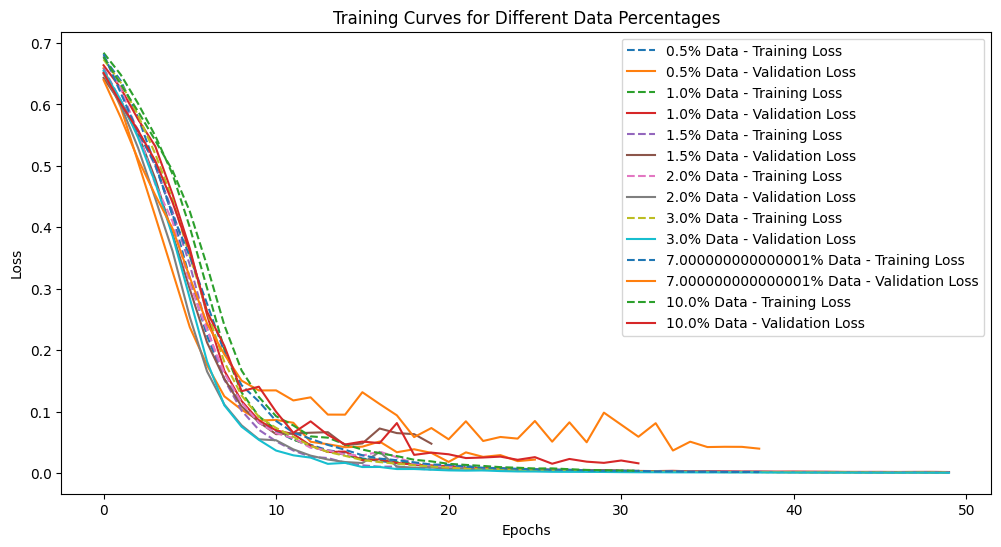

In [23]:
# Plotting the Training Curves
plt.figure(figsize=(12, 6))
for i, (train_losses, val_losses) in enumerate(training_curves):
    plt.plot(train_losses, label=f"{percentages[i]*100}% Data - Training Loss", linestyle='--')
    plt.plot(val_losses, label=f"{percentages[i]*100}% Data - Validation Loss")
    
plt.title("Training Curves for Different Data Percentages")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [24]:
class ETETransferModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_transfer, dropout_prob=0.15):
        super(ETETransferModel, self).__init__()
        # Copy the layers from the pretrained model
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, output_dim_trnsfr)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [25]:
# Extracting features and labels from your dataset
features = [item[0] for item in transfer_dataset]
labels = [item[1] for item in transfer_dataset]

# Encode the labels from {1, 3} to {0, 1}
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Your percentage list
percentages = [0.005, 0.01, 0.015, 0.02, 0.03, 0.07, 0.1]

# Storage for models and their training curves
trained_models_ete = []
training_curves_ete = []

for percentage in percentages:
    # Sample the data
    _, sampled_features, _, sampled_labels = train_test_split(
    features, encoded_labels,  # <-- Use encoded_labels here
    train_size=percentage,
    stratify=encoded_labels,  # <-- And here
    random_state=42  # for reproducibility
    )
    
    # Now, combine the sampled_features and sampled_labels to form the sampled dataset
    sampled_data = list(zip(sampled_features, sampled_labels))
    
    # Splitting the sampled_data further into train, validation, and test sets
    transfer_train_size = int(train_ratio * len(sampled_data))
    transfer_val_size = int(val_ratio * len(sampled_data))
    transfer_test_size = len(sampled_data) - transfer_train_size - transfer_val_size
    
    # Ensure each split has at least one sample
    while transfer_train_size < 1:
        transfer_train_size += 1
        transfer_val_size -= 1
        
    while transfer_val_size < 1:
        transfer_val_size += 1
        transfer_train_size -= 1
    
    transfer_train_dataset, transfer_val_dataset, _ = random_split(sampled_data, [transfer_train_size, transfer_val_size, transfer_test_size])
    
    # Create dataloaders
    transfer_train_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=batch_size, shuffle=True)
    transfer_val_loader = torch.utils.data.DataLoader(transfer_val_dataset, batch_size=batch_size, shuffle=True)
    
    # Create a new model for transfer learning
    transfer_model_ete = ETETransferModel(input_dim, hidden_dim, output_dim_trnsfr)
    transfer_model_ete.to(device)

    # Define optimizer only for the unfrozen layer
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=0.001)
    
    # Lists to store losses for this model
    train_losses = []
    val_losses = []
    
    # Training loop
    epochs = 50
    patience = 5  # Number of epochs to wait before stopping
    wait = 0
    best_loss = float('inf')

    for epoch in range(epochs):
        # Training phase
        transfer_model.train()
        train_loss = 0.0
        for data, target in transfer_train_loader:
            optimizer.zero_grad()
            output = transfer_model_ete(data.float().to(device))
            loss = criterion(output.float().to(device), target.long().to(device))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(transfer_train_loader)

        # Validation phase
        transfer_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in transfer_val_loader:
                output = transfer_model_ete(data.float().to(device))
                loss = criterion(output.float().to(device), target.long().to(device))
                val_loss += loss.item()

        val_loss /= len(transfer_val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss}, Validation Loss: {val_loss}")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Check early stopping condition
        if val_loss < best_loss:
            best_loss = val_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping!")
                break

    # Append the trained model to the list
    trained_models_ete.append(transfer_model)
    training_curves_ete.append((train_losses, val_losses))

Epoch 1/50 - Training Loss: 0.6963353488180373, Validation Loss: 0.6910854429006577
Epoch 2/50 - Training Loss: 0.6963680187861124, Validation Loss: 0.6893005073070526
Epoch 3/50 - Training Loss: 0.6958210269610087, Validation Loss: 0.6897405385971069
Epoch 4/50 - Training Loss: 0.6960466007391611, Validation Loss: 0.69036665558815
Epoch 5/50 - Training Loss: 0.6964383191532559, Validation Loss: 0.6897197216749191
Epoch 6/50 - Training Loss: 0.6966575185457865, Validation Loss: 0.6897286474704742
Epoch 7/50 - Training Loss: 0.695913185675939, Validation Loss: 0.6900119930505753
Early stopping!
Epoch 1/50 - Training Loss: 0.6944446994198693, Validation Loss: 0.6956169456243515
Epoch 2/50 - Training Loss: 0.6942981547779508, Validation Loss: 0.6955336034297943
Epoch 3/50 - Training Loss: 0.6942985355854034, Validation Loss: 0.6958557367324829
Epoch 4/50 - Training Loss: 0.6941697663731046, Validation Loss: 0.6956414133310318
Epoch 5/50 - Training Loss: 0.6941100160280863, Validation Loss

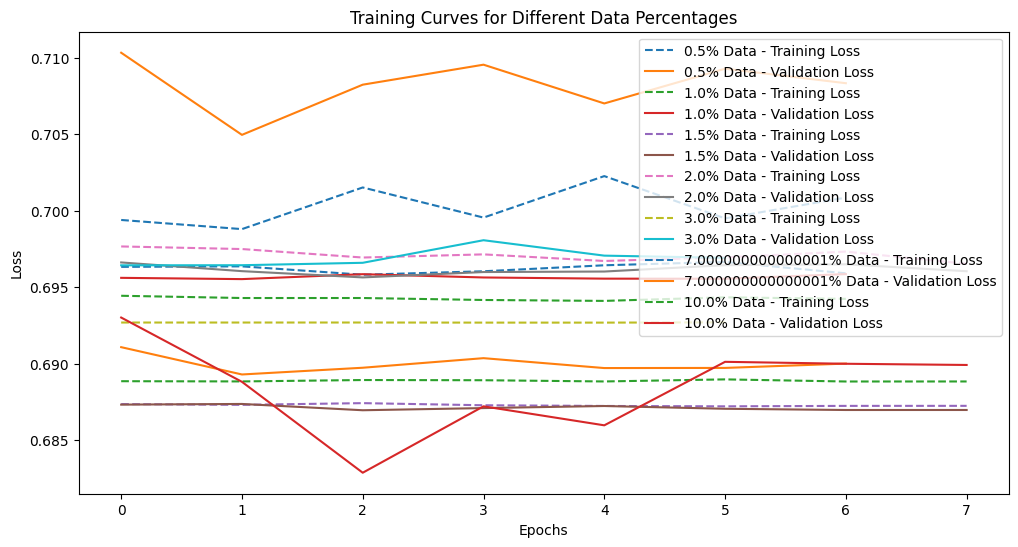

In [26]:
# Plotting the Training Curves
plt.figure(figsize=(12, 6))
for i, (train_losses, val_losses) in enumerate(training_curves_ete):
    plt.plot(train_losses, label=f"{percentages[i]*100}% Data - Training Loss", linestyle='--')
    plt.plot(val_losses, label=f"{percentages[i]*100}% Data - Validation Loss")
    
plt.title("Training Curves for Different Data Percentages")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
test_loaders = []

for percentage in percentages:
    # Sample the data using train_test_split
    _, sampled_features, _, sampled_labels = train_test_split(
        features, encoded_labels,  # Use the entire feature set and encoded labels
        train_size=percentage,
        stratify=encoded_labels,  # Ensure stratified sampling based on the encoded labels
        random_state=42  # For reproducibility
    )
    
    # Assuming you have a Dataset class that can consume the sampled_features and sampled_labels
    # For this example, let's say it's named CustomDataset
    transfer_test_dataset = CustomDataset(sampled_features, sampled_labels) 

    # Create a DataLoader from the sampled dataset
    transfer_test_loader = torch.utils.data.DataLoader(transfer_test_dataset, batch_size=batch_size, shuffle=False)
    test_loaders.append(transfer_test_loader)


In [34]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float().to(device), target.long().to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    test_loss /= len(test_loader)
    return test_loss, accuracy

In [35]:
test_results = []
test_results_ete = []    

criterion = nn.CrossEntropyLoss()

for i in range(len(percentages)):
    loss, accuracy = evaluate(trained_models[i], test_loaders[i], criterion, device)
    test_results.append((loss, accuracy))

    loss_ete, accuracy_ete = evaluate(trained_models_ete[i], test_loaders[i], criterion, device)
    test_results_ete.append((loss_ete, accuracy_ete))

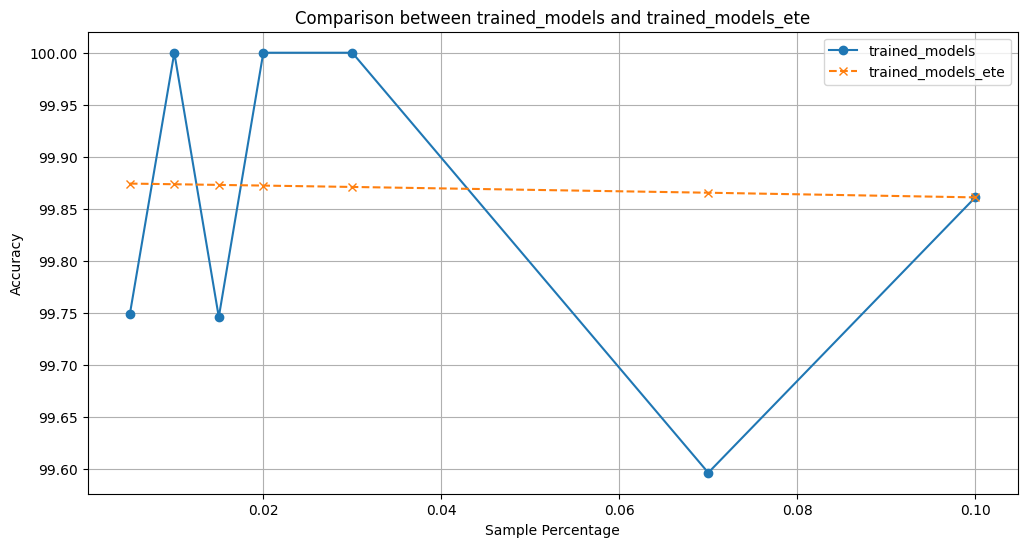

In [40]:
import matplotlib.pyplot as plt

accuracies = [x[1] for x in test_results]
accuracies_ete = [x[1] for x in test_results_ete]

# Plotting
plt.figure(figsize=(12, 6))

# Plot for trained_models
plt.plot(percentages, accuracies, marker='o', label='trained_models', linestyle='-')

# Plot for trained_models_ete
plt.plot(percentages, accuracies_ete, marker='x', label='trained_models_ete', linestyle='--')

# Setting labels, title, legend, and grid
plt.xlabel('Sample Percentage')
plt.ylabel('Accuracy')
plt.title('Comparison between trained_models and trained_models_ete')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()